In [1]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter
import scipy.stats
from scipy.stats import zscore

from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt

import seaborn as sns 
import bk.load
import bk.compute
import bk.plot
import bk.signal
import bk.stats

import os


import astropy.stats as apy
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
def main(base_folder,local_path,*args,**kwargs):
    

    if kwargs:
        stru = kwargs['stru']
        plot = kwargs['plot']
        save = kwargs['save']


    bk.load.current_session_linux(base_folder,local_path)
    # data = bk.load.analysis(f'Power_spectrums/laps_{stru}')
    # if  data  is not False:
    #     return data
    
    laps = bk.load.intervals('laps')
    lfps = {}
    for lap in laps:
        lfps.update({lap:bk.load.lfp_in_intervals(bk.load.random_channel(stru),laps[lap])})

    spectrums = {}
    for lap,lfp in lfps.items():
        freqs,spectrum = scipy.signal.welch(lfp.values,1250,nperseg=1000,noverlap=750)
        f,s = bk.signal.flatten_spectrum(freqs,spectrum,[2,120])
        spectrums.update({lap:s})



    if plot:
        plt.figure()
        for lap,s in spectrums.items():
            print(lap)
            plt.plot(f,s)
            plt.legend(laps.keys())
    if save:
        np.save(f'Analysis/Power_spectrums/laps_{stru}.npy',(f,spectrums))

    return f,spectrums


In [3]:
def merge(batch):
    spectrums = {'aversive':[],
                'safe':[]}
    for sess,b in batch.items():
        if type(b) is not bool:
            for s in spectrums:
                spectrums[s].append(b[1][s])
            
            f = b[0]
    return f,spectrums
        

In [4]:
stru = ['Hpc','BLA','CeCM']
batch = {}
metadata = {}
for s in stru:

    kwargs = {
        'stru':s,
        'plot': False,
        'save':True
    }

    batch_,metadata_ = bk.load.batch(main,local_base='/mnt/electrophy/Gabrielle/GG-Dataset-Light',**kwargs)
    batch.update({s:batch_})
    metadata.update({s:metadata_})

100%|██████████| 61/61 [04:57<00:00,  4.88s/it]

Batch finished in 297.7241542339325
Some session were not processed correctly
['Rat08-20130712', 'Rat08-20130713', 'Rat08-20130715', 'Rat08-20130716', 'Rat08-20130717', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140328', 'Rat09-20140329', 'Rat09-20140331', 'Rat09-20140401', 'Rat09-20140402', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140628', 'Rat10-20140629', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150315', 'Rat11-20150327', 'Rat11-20150328', 'Rat11-20150330', 'Rat11-20150331', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
60.65573770491803 %


In [9]:
spec = {}
for s in stru:
    f,spec_ = merge(batch[s])
    spec.update({s:spec_})

In [7]:
def plot_confidence_intervals(x,y,style = '',ax = None):
    if ax is None:
        fig,ax = plt.subplots(1,1)
    
    conf = 1.96*scipy.stats.sem(y,0)
    m = np.mean(y,0)
    ax.plot(x,m,style)
    ax.fill_between(x,m+conf,m-conf,color = style,alpha = 0.2)


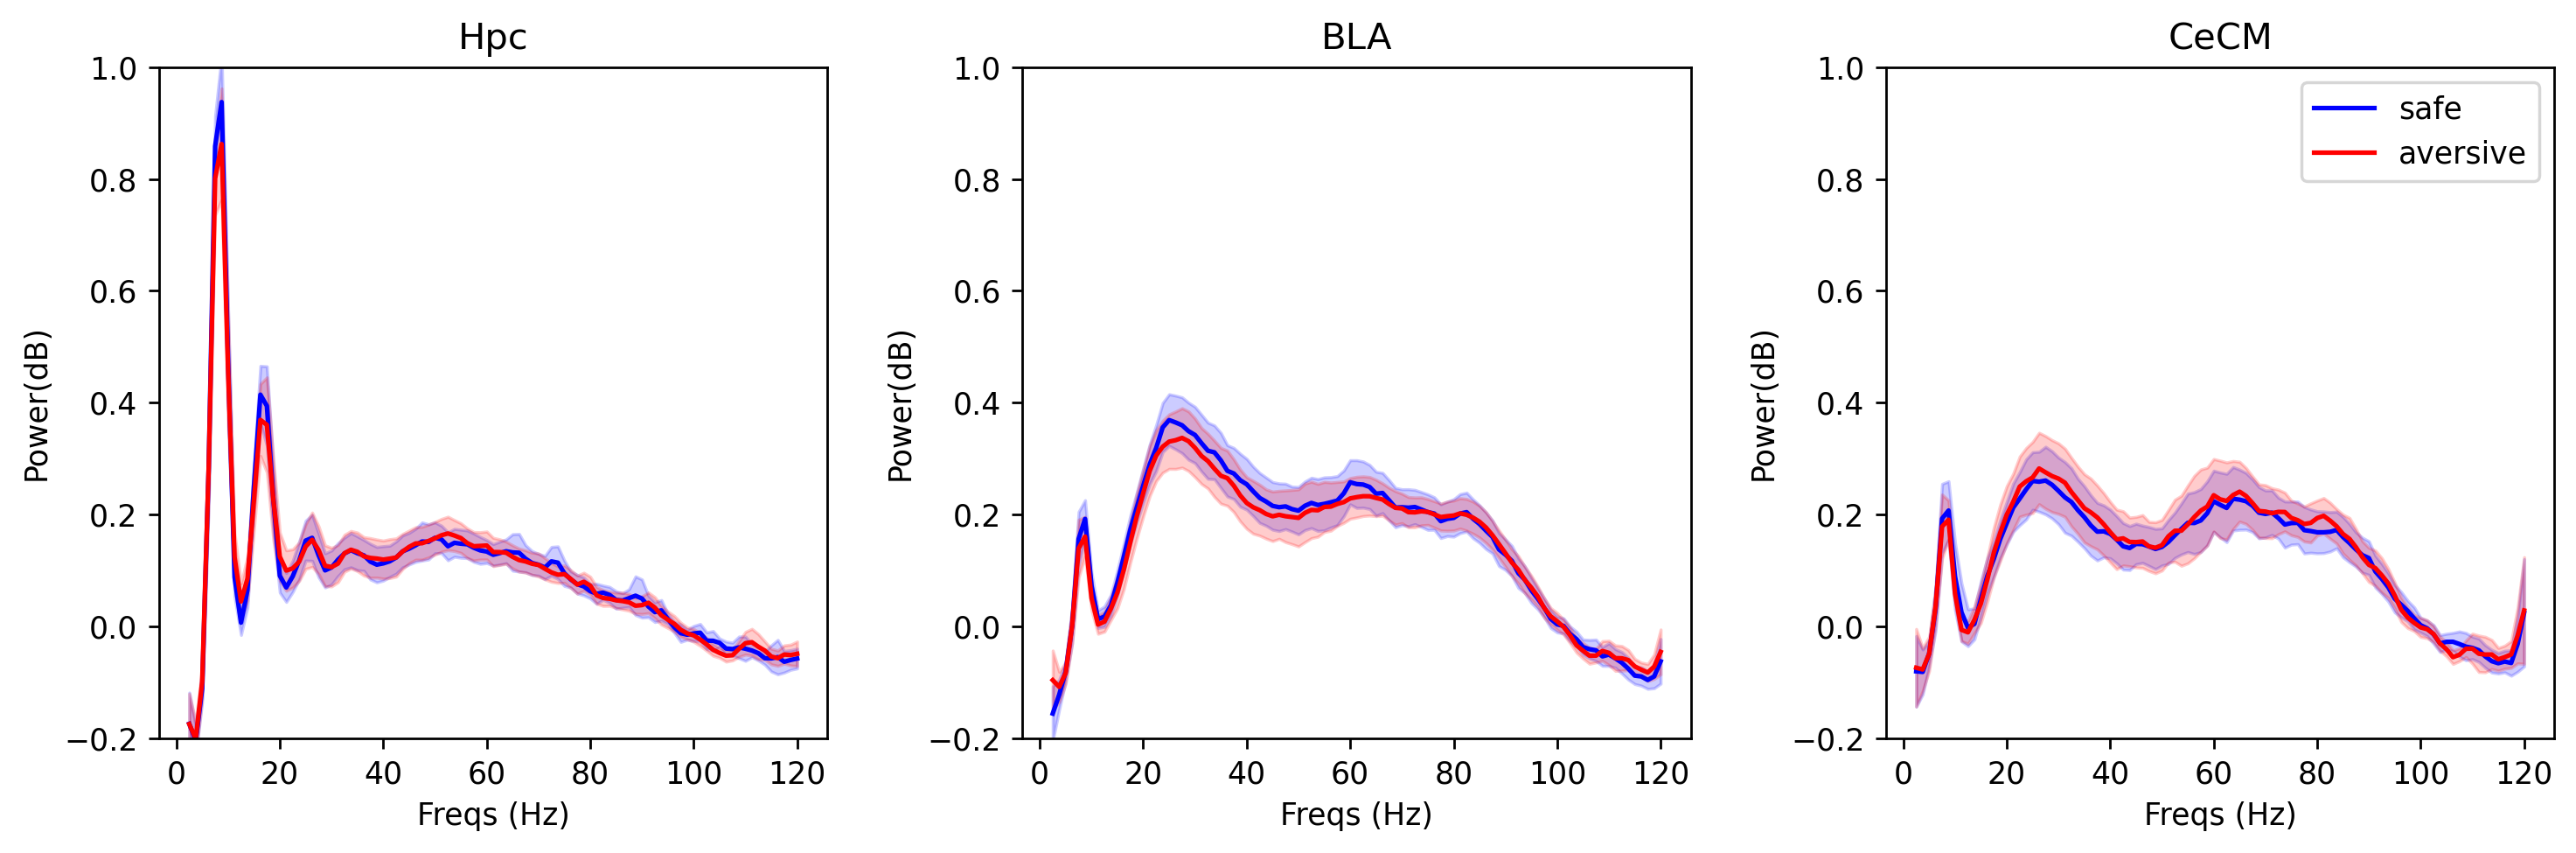

In [10]:
fig,ax = plt.subplots(1,3,figsize = (12,4),dpi = 250)

for s,a in zip(stru,ax):
    plot_confidence_intervals(f,spec[s]['safe'],'b',a)
    plot_confidence_intervals(f,spec[s]['aversive'],'r',a)
    a.set_title(s)
    a.set_ylabel('Power(dB)')
    a.set_xlabel('Freqs (Hz)')
    a.set_ylim(-0.2,1)

plt.tight_layout()
plt.legend(['safe','aversive'])

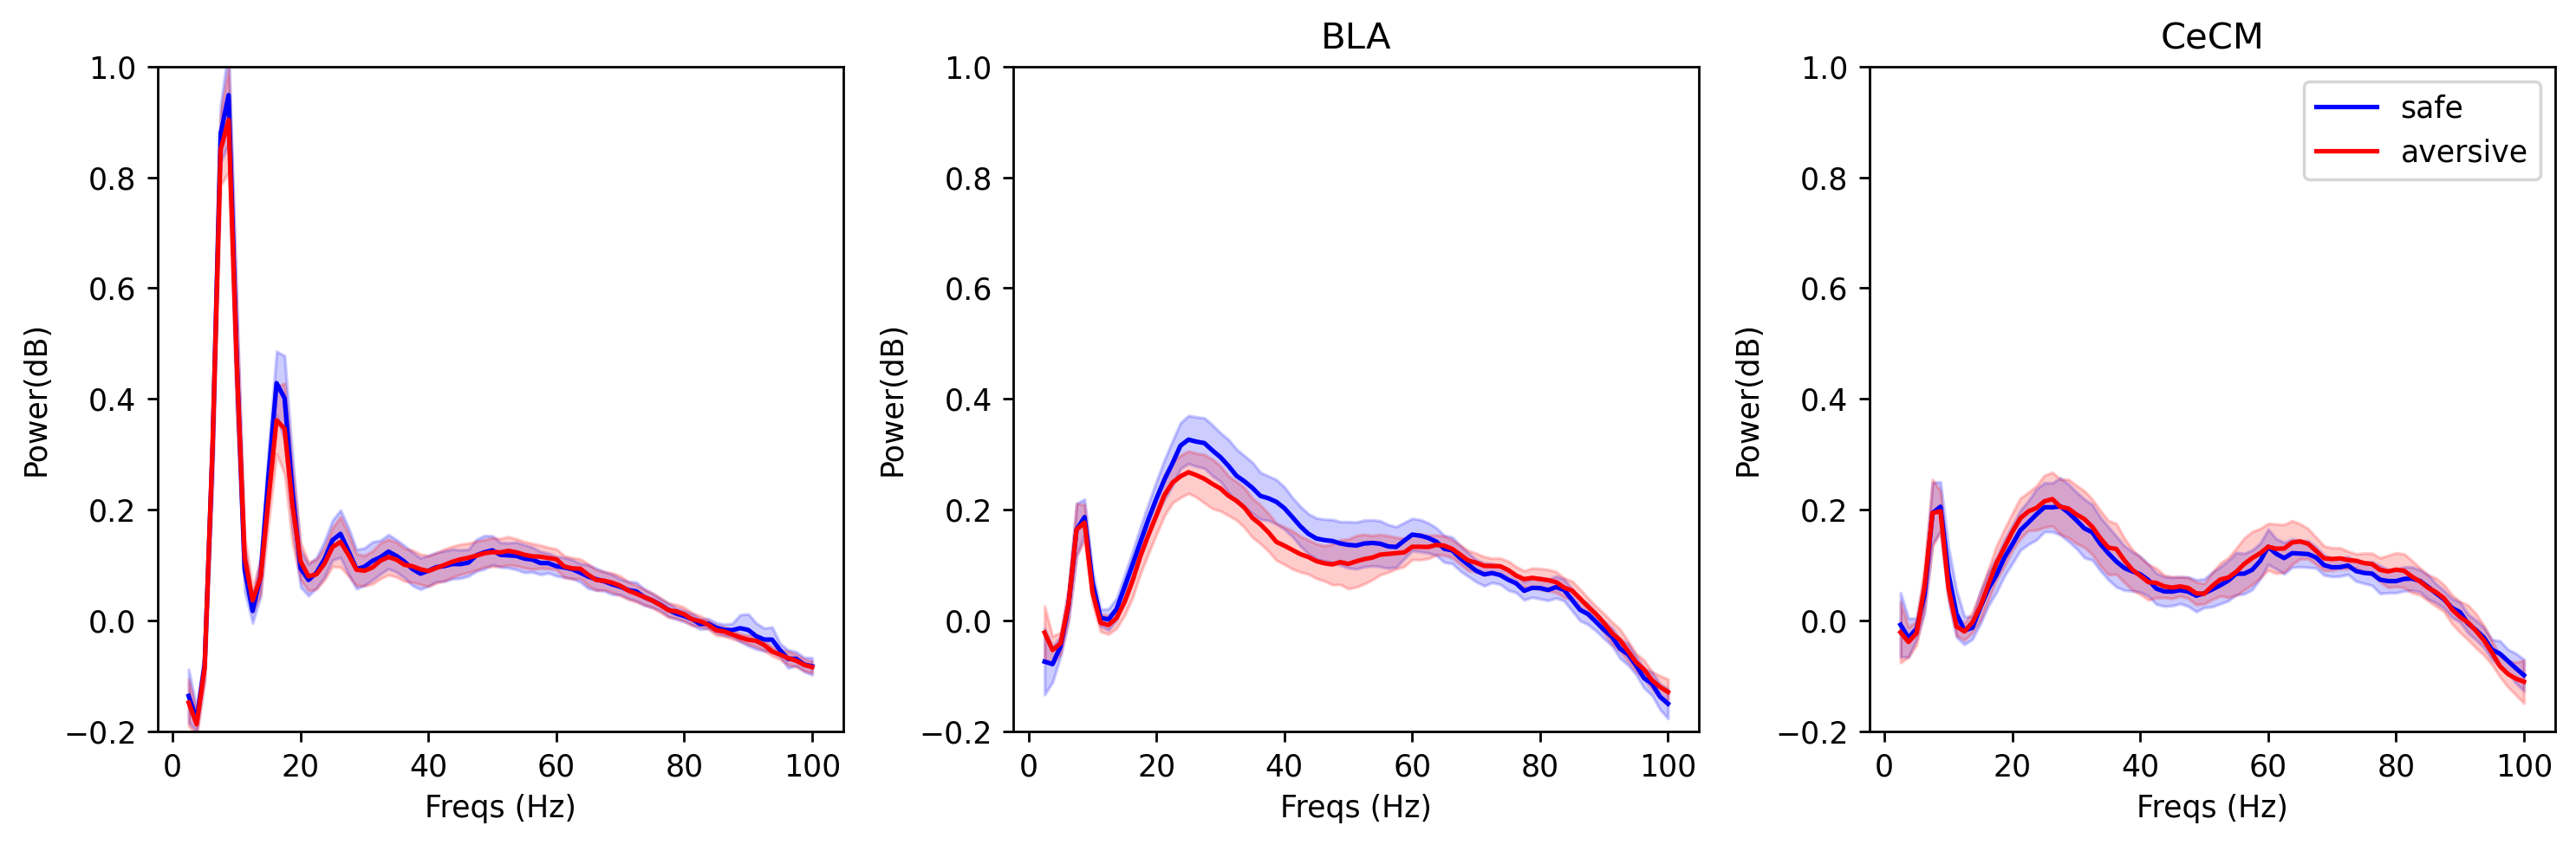

In [37]:
fig,ax = plt.subplots(1,3,figsize = (12,4),dpi = 250)

plot_confidence_intervals(f,spec_hpc['safe'],'b',ax[0])
plot_confidence_intervals(f,spec_hpc['aversive'],'r',ax[0])
ax[0].set_title('')
ax[0].set_ylabel('Power(dB)')
ax[0].set_xlabel('Freqs (Hz)')


plot_confidence_intervals(f,spec_bla['safe'],'b',ax[1])
plot_confidence_intervals(f,spec_bla['aversive'],'r',ax[1])
ax[1].set_title('BLA')
ax[1].set_ylabel('Power(dB)')
ax[1].set_xlabel('Freqs (Hz)')


plot_confidence_intervals(f,spec_cecm['safe'],'b',ax[2])
plot_confidence_intervals(f,spec_cecm['aversive'],'r',ax[2])
ax[2].set_title('CeCM')
ax[2].set_ylabel('Power(dB)')
ax[2].set_xlabel('Freqs (Hz)')

for i in ax:
    i.set_ylim(-0.2,1)

plt.tight_layout()
plt.legend(['safe','aversive'])


In [75]:
spec[0]

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed